<a href="https://colab.research.google.com/github/dipayandas97/Deep-Learning-Notebooks/blob/master/Predicting_COVID_19_cases_in_India_June_5_July_7%2C_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [47]:
data = pd.read_csv('/content/drive/My Drive/ISI/COVID-19/saggy_covid_time_series_india.txt', delimiter='\t')
data.head(-1)

,date,country,confirmed,recovered,death
0,2020-01-22,India,0,0,0
1,2020-01-23,India,0,0,0
2,2020-01-24,India,0,0,0
3,2020-01-25,India,0,0,0
4,2020-01-26,India,0,0,0
...,...,...,...,...,...
130,2020-05-31,India,190609,91852,5408
131,2020-06-01,India,198370,95754,5608
132,2020-06-02,India,207191,100285,5829
133,2020-06-03,India,216824,104071,6088


In [0]:
confirmed = data['confirmed'].to_numpy()
recovered = data['recovered'].to_numpy()
death = data['death'].to_numpy()
days = np.arange(0,136)

print('Confirmed: ',confirmed.shape, 'Recovered: ', recovered.shape, 'Death:', death.shape)
plt.figure(figsize=(10,6))
plt.xlabel('Days from Jan 22,2020', fontsize=16)
plt.ylabel('Confirmed Cases', fontsize=16)
plt.plot(confirmed, label='confirmed')
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(10,6))
plt.xlabel('Days from Jan 22,2020', fontsize=16)
plt.ylabel('Recovered Cases', fontsize=16)
plt.plot(recovered, label='recovered')
plt.legend(fontsize=16)
plt.show()

plt.figure(figsize=(10,6))
plt.xlabel('Days from Jan 22,2020', fontsize=16)
plt.ylabel('Death Cases', fontsize=16)
plt.plot(death, label='death')
plt.legend(fontsize=16)
plt.show()

In [0]:
#Windowing function
#last column of returned array is output

def get_windowed_data(data, window_size):
    if len(data.shape)==1:
        XY = data[0:window_size+1].reshape(1,window_size+1)
        for i in range(1,data.shape[0]-window_size):
            XY = np.vstack((XY, data[i:i+window_size+1].reshape(1,window_size+1)))
    return XY

In [0]:
window_size = 5

In [0]:
WD_confirmed = get_windowed_data(confirmed, window_size)
WD_recovered = get_windowed_data(recovered, window_size)
WD_death = get_windowed_data(death, window_size)
WD_days = get_windowed_data(days, window_size)

#changing data here
wD = WD_confirmed
wD_real = confirmed
wD_name = 'Confirmed'

wD_ = wD / np.max(wD) #Since all data start from 0, so min(data) = 0, so d = d-min/max-min becomes d = d/max

In [177]:
X = wD_[:,:-1]
Y = wD_[:,-1]

X_train, X_test, y_train, y_test = X[:120], X[120:], Y[:120], Y[120:]

print(X_train.shape, y_train.shape)

(120, 5) (120,)


In [0]:
from keras.layers import *
from keras.models import Model

inp = Input(shape=(window_size,))
x = Dense(12, activation='relu')(inp)
x = Dense(4, activation='relu')(x)
x = Dense(1, activation='relu')(x)

model = Model(inp, x)
model.compile(loss='mse', optimizer='adam')

In [0]:
model.fit(X, Y, epochs=500, batch_size=8, shuffle=True, validation_data=(X_test, y_test))

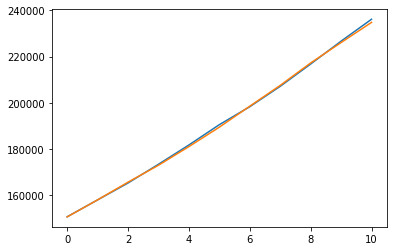

In [180]:
unscaled_test_data = np.hstack((X_test,y_test.reshape(y_test.shape[0],1)))
unscaled_y_test = (np.max(wD)*unscaled_test_data)[:,-1]
plt.plot(unscaled_y_test)

unscaled_test_data_eval = np.hstack((X_test,model.predict(X_test).reshape(y_test.shape[0],1)))
unscaled_y_test_eval = (np.max(wD)*unscaled_test_data_eval)[:,-1]
plt.plot(unscaled_y_test_eval)

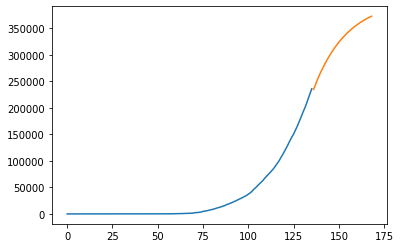

In [182]:
#Predict for June 05 to July 7 # N = 33 

data = X[-1,:].reshape(1,window_size)
prediction = []

for i in range(33):
    pred = model.predict(data).reshape(1,1)
    real_pred = np.max(wD)*pred[0]
    prediction.append(real_pred)
    new_data = [x for x in data[0,1:]]
    new_data.append(pred[0][0])
    data = np.asarray(new_data).reshape(1, window_size)

plt.plot(np.arange(136),wD_real)
plt.plot(np.arange(33)+136,prediction)
plt.show()

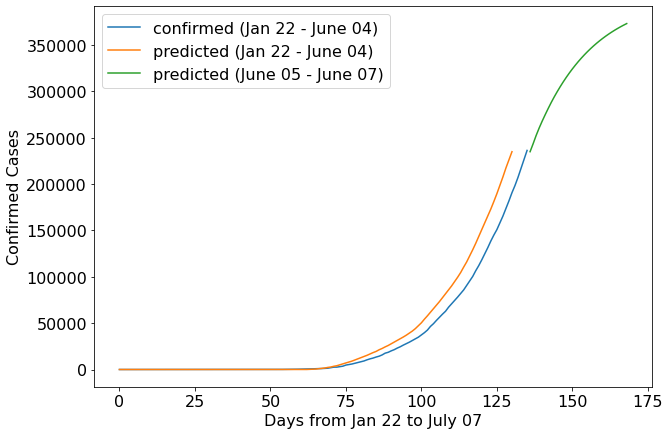

In [184]:
plt.figure(figsize=(10,7))
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.ylabel(wD_name+' Cases', fontsize=16)
plt.xlabel('Days from Jan 22 to July 07', fontsize=16)

plt.plot(wD_real, label='confirmed (Jan 22 - June 04)')

unscaled_test_data_eval = np.hstack((X,model.predict(X).reshape(X.shape[0],1)))
unscaled_y_test_eval = (np.max(wD)*unscaled_test_data_eval)[:,-1]
plt.plot(unscaled_y_test_eval, label='predicted (Jan 22 - June 04)')

plt.plot(np.arange(33)+len(wD_real),prediction, label='predicted (June 05 - June 07)')
plt.legend(fontsize=16)
plt.show()